In [ ]:
#Cài đặt thư viện
!pip install tf_slim
!pip install scrapbook
!pip install papermill
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 9.6 MB/s 
     |████████████████████████████████| 71 kB 179 kB/s 
     |████████████████████████████████| 107 kB 41.5 MB/s 
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.1.1
    Uninstalling traitlets-5.1.1:
      Successfully uninstalled traitlets-5.1.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 4.8 MB/s 
     |████████████████████████████████| 11.8 MB 45.5 MB/s 
     |████████████████████████████████| 310 kB 52.4 MB/s 
     |████████████████████████████████

In [ ]:
#Thiết lập môi trường
import sys
import os
import shutil
import papermill as pm
import scrapbook as sb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sn
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from recommenders.utils.constants import SEED as DEFAULT_SEED


print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]
Pandas version: 1.3.5
Tensorflow version: 2.8.2


In [ ]:
# top k mặt hàng đề xuát
TOP_K = 10

# Lựa chọn kích thước data MovieLens 20m
MOVIELENS_DATA_SIZE = '100k'

# Tham số mô hình
EPOCHS = 100
BATCH_SIZE = 256

SEED = DEFAULT_SEED  # Set None for non-deterministic results

In [ ]:
ratings = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE, header=["userID", "itemID", "rating", "timestamp"])

ratings.head(5)

100%|██████████| 4.81k/4.81k [00:00<00:00, 16.5kKB/s]


,userID,itemID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [ ]:
#Thống kê giá trị bị thiếu
missing = pd.DataFrame(round(ratings.isna().sum()/ratings.isna().count()*100,2))
missing.rename(columns={0:'Percentage of missing values'}, inplace=True)
missing['Percentage of missing values']=missing['Percentage of missing values'].map(str)+'%'
missing

,Percentage of missing values
userID,0.0%
itemID,0.0%
rating,0.0%
timestamp,0.0%


In [ ]:
des_stat = ratings.describe()
des_stat

,userID,itemID,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [ ]:
#Data info
print (ratings.info)
cols_list = ratings.columns.to_list()

<bound method DataFrame.info of        userID  itemID  rating  timestamp
0         196     242     3.0  881250949
1         186     302     3.0  891717742
2          22     377     1.0  878887116
3         244      51     2.0  880606923
4         166     346     1.0  886397596
...       ...     ...     ...        ...
99995     880     476     3.0  880175444
99996     716     204     5.0  879795543
99997     276    1090     1.0  874795795
99998      13     225     2.0  882399156
99999      12     203     3.0  879959583

[100000 rows x 4 columns]>


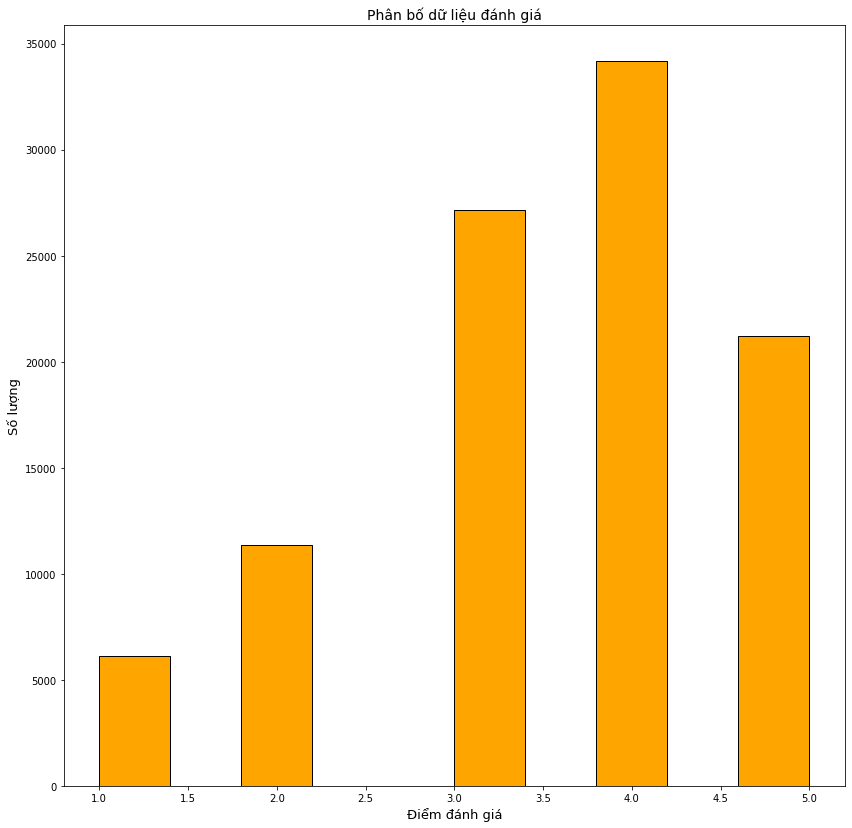

In [ ]:
fig = plt.figure(figsize = ([14, 14]))
plt.xlabel("Điểm đánh giá", fontsize=13)
plt.ylabel("Số lượng", fontsize=13)
plt.title("Phân bố dữ liệu đánh giá", fontsize=14)
plt.hist(ratings['rating'], color = 'orange', edgecolor = 'black')
plt.show()

In [ ]:
train, test = python_chrono_split(ratings, 0.75)

In [ ]:
#Tạo tập kiểm thử chứa tương tác cuối cùng cho mỗi người dùng để sử dụng cho đánh giá leave-one-out.
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [ ]:
leave_one_out_test = test.groupby("userID").last().reset_index()

In [ ]:
train_file = "./train.csv"
test_file = "./test.csv"
leave_one_out_test_file = "./leave_one_out_test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)
leave_one_out_test.to_csv(leave_one_out_test_file, index=False)

In [ ]:
data = NCFDataset(train_file=train_file, test_file=leave_one_out_test_file, seed=SEED, overwrite_test_file_full=True)

100%|██████████| 943/943 [00:14<00:00, 66.58it/s] 


In [ ]:
#Huấn  luyện mô hình
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

Took 844.2073864920001 seconds for training.


In [ ]:
#Dự đoán
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test.iterrows()]


predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.sample(10)

,userID,itemID,prediction
5098,207.0,520.0,0.273485
12613,450.0,1222.0,0.006611
3236,125.0,395.0,0.064563
24053,907.0,313.0,0.768385
15274,542.0,230.0,0.044937
12902,456.0,395.0,0.000714
4094,172.0,483.0,0.673344
16195,588.0,72.0,0.535338
5628,230.0,570.0,0.061759
5169,210.0,502.0,0.186209


In [ ]:
predictions.to_excel("Predictions.xlsx")

**GENERIC EVALUATION**

In [ ]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 4.390618026000084 seconds for prediction.


In [ ]:
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.046276
NDCG:	0.195943
Precision@K:	0.179533
Recall@K:	0.098352


In [ ]:
k = [1,2,3,4, 5, 6, 7, 8, 9, 10]
ndcg_lst = []
for Top_K in k:
  eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=Top_K)
  ndcg_lst.append(eval_ndcg)
print (ndcg_lst)

[0.22481442205726404, 0.2174301691089907, 0.21244460530361312, 0.20988877029133024, 0.20349894243577285, 0.20204001233694302, 0.20005252127350776, 0.19839802780934698, 0.19827638090978064, 0.19830829936258546]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


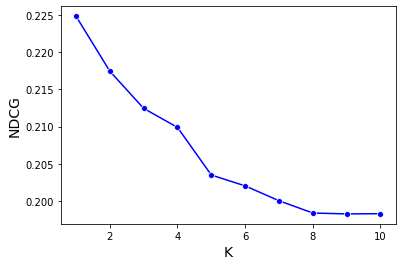

In [ ]:
x = k
y = ndcg_lst
sn.lineplot(x,y, color= 'blue', marker = 'o', linestyle = '-')
plt.xlabel("K", fontsize = 14)
plt.ylabel("NDCG", fontsize=14)
plt.show()


**LEAVE ONE OUT EVALUATION**

In [ ]:
k = TOP_K

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("HR:\t%f" % eval_hr)
print("NDCG:\t%f" % eval_ndcg)

HR:	0.515376
NDCG:	0.409265


**PRE TRAINING**

In [ ]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="GMF",
    n_factors=64,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))
model.save(dir_name=".pretrain/GMF")

Took 1144.9467716990002 seconds for training.


In [ ]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="MLP",
    n_factors=64,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
    ) 

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/MLP")

Took 794.1426483880005 seconds for training.


**LOAD  PRE-TRAINED MODEL**

In [ ]:
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=64,
    layer_sizes=[16,8,4],
    n_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

model.load(gmf_dir=".pretrain/GMF", mlp_dir=".pretrain/MLP", alpha=0.5)

In [ ]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

Took 1142.5429404489987 seconds for training.


In [ ]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 4.918642357000863 seconds for prediction.


In [ ]:
eval_map2 = map_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_ndcg2 = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision2 = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall2 = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map2,
      "NDCG:\t%f" % eval_ndcg2,
      "Precision@K:\t%f" % eval_precision2,
      "Recall@K:\t%f" % eval_recall2, sep='\n')

MAP:	0.024354
NDCG:	0.126189
Precision@K:	0.116119
Recall@K:	0.063030


In [ ]:
# Record results with papermill for tests
sb.glue("map", eval_map)
sb.glue("ndcg", eval_ndcg)
sb.glue("precision", eval_precision)
sb.glue("recall", eval_recall)
sb.glue("map2", eval_map2)
sb.glue("ndcg2", eval_ndcg2)
sb.glue("precision2", eval_precision2)
sb.glue("recall2", eval_recall2)

In [ ]:
save_dir = ".pretrain"
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    
print("Did \'%s\' exist?: %s" % (save_dir, os.path.exists(save_dir)))

Did '.pretrain' exist?: False
